In [1]:
import os
import glob
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [96]:
util.set_sns_style(style='dark')
%matplotlib notebook

In [187]:
root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
experiment = 'Spontaneous_edge_tracking' 

fig_id = os.path.join(root_dir.split('/My Drive')[1], experiment)
src_dir = os.path.join(root_dir, experiment)
save_dir = '/Users/julianarhee/Documents/rutalab/data/figures/{}/rdp'.format(experiment)
save_dir = save_dir.replace(" ", "")

print("Saving figures to:{}    {}".format('\n', save_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking/rdp


In [4]:
log_files = sorted([k for k in glob.glob(os.path.join(src_dir, '*.log'))\
                if 'lossed tracking' not in k], key=util.natsort)
print("Found {} tracking files.".format(len(log_files)))
#log_files

Found 13 tracking files.


In [5]:
# Load dataframes
dlist = []
for fpath in log_files:
    #air_only = '_Air' in fpath or '_air' in fpath
    #print(fpath, air_only)
    exp, datestr, fly_id, cond = butil.parse_info_from_file(fpath)
    df_ = butil.load_dataframe(fpath, mfc_id=None, verbose=False, cond=None)
    dlist.append(df_)
df0 = pd.concat(dlist, axis=0)
df0.loc[df0['condition']=='light', 'condition'] = 'lightonly'

In [95]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [6]:
fly_ids = sorted(df0['fly_id'].unique(), key=util.natsort)
fly_ids

['20220530-fly0',
 '20220602-fly1',
 '20220602-fly2',
 '20220602-fly3',
 '20220609-fly1',
 '20220609-fly2',
 '20220609-fly3',
 '20220609-fly4',
 '20220613-fly5',
 '20220613-fly6',
 '20220613-fly7',
 '20220613-fly8',
 '20220613-fly9']

In [7]:
# get odor border for each fly
odor_width=50
grid_sep=200
odor_borders={}
for fly_id, currdf in df0.groupby(['fly_id']):
    ogrid = butil.get_odor_grid(currdf, 
                                odor_width=odor_width, grid_sep=grid_sep,
                                use_crossings=True, verbose=False)
    (odor_xmin, odor_xmax), = ogrid.values()
    odor_borders.update({fly_id: (odor_xmin, odor_xmax)})

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_20541/334420578.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fly_id, currdf in df0.groupby(['fly_id']):


Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True
Crossings? True


<IPython.core.display.Javascript object>


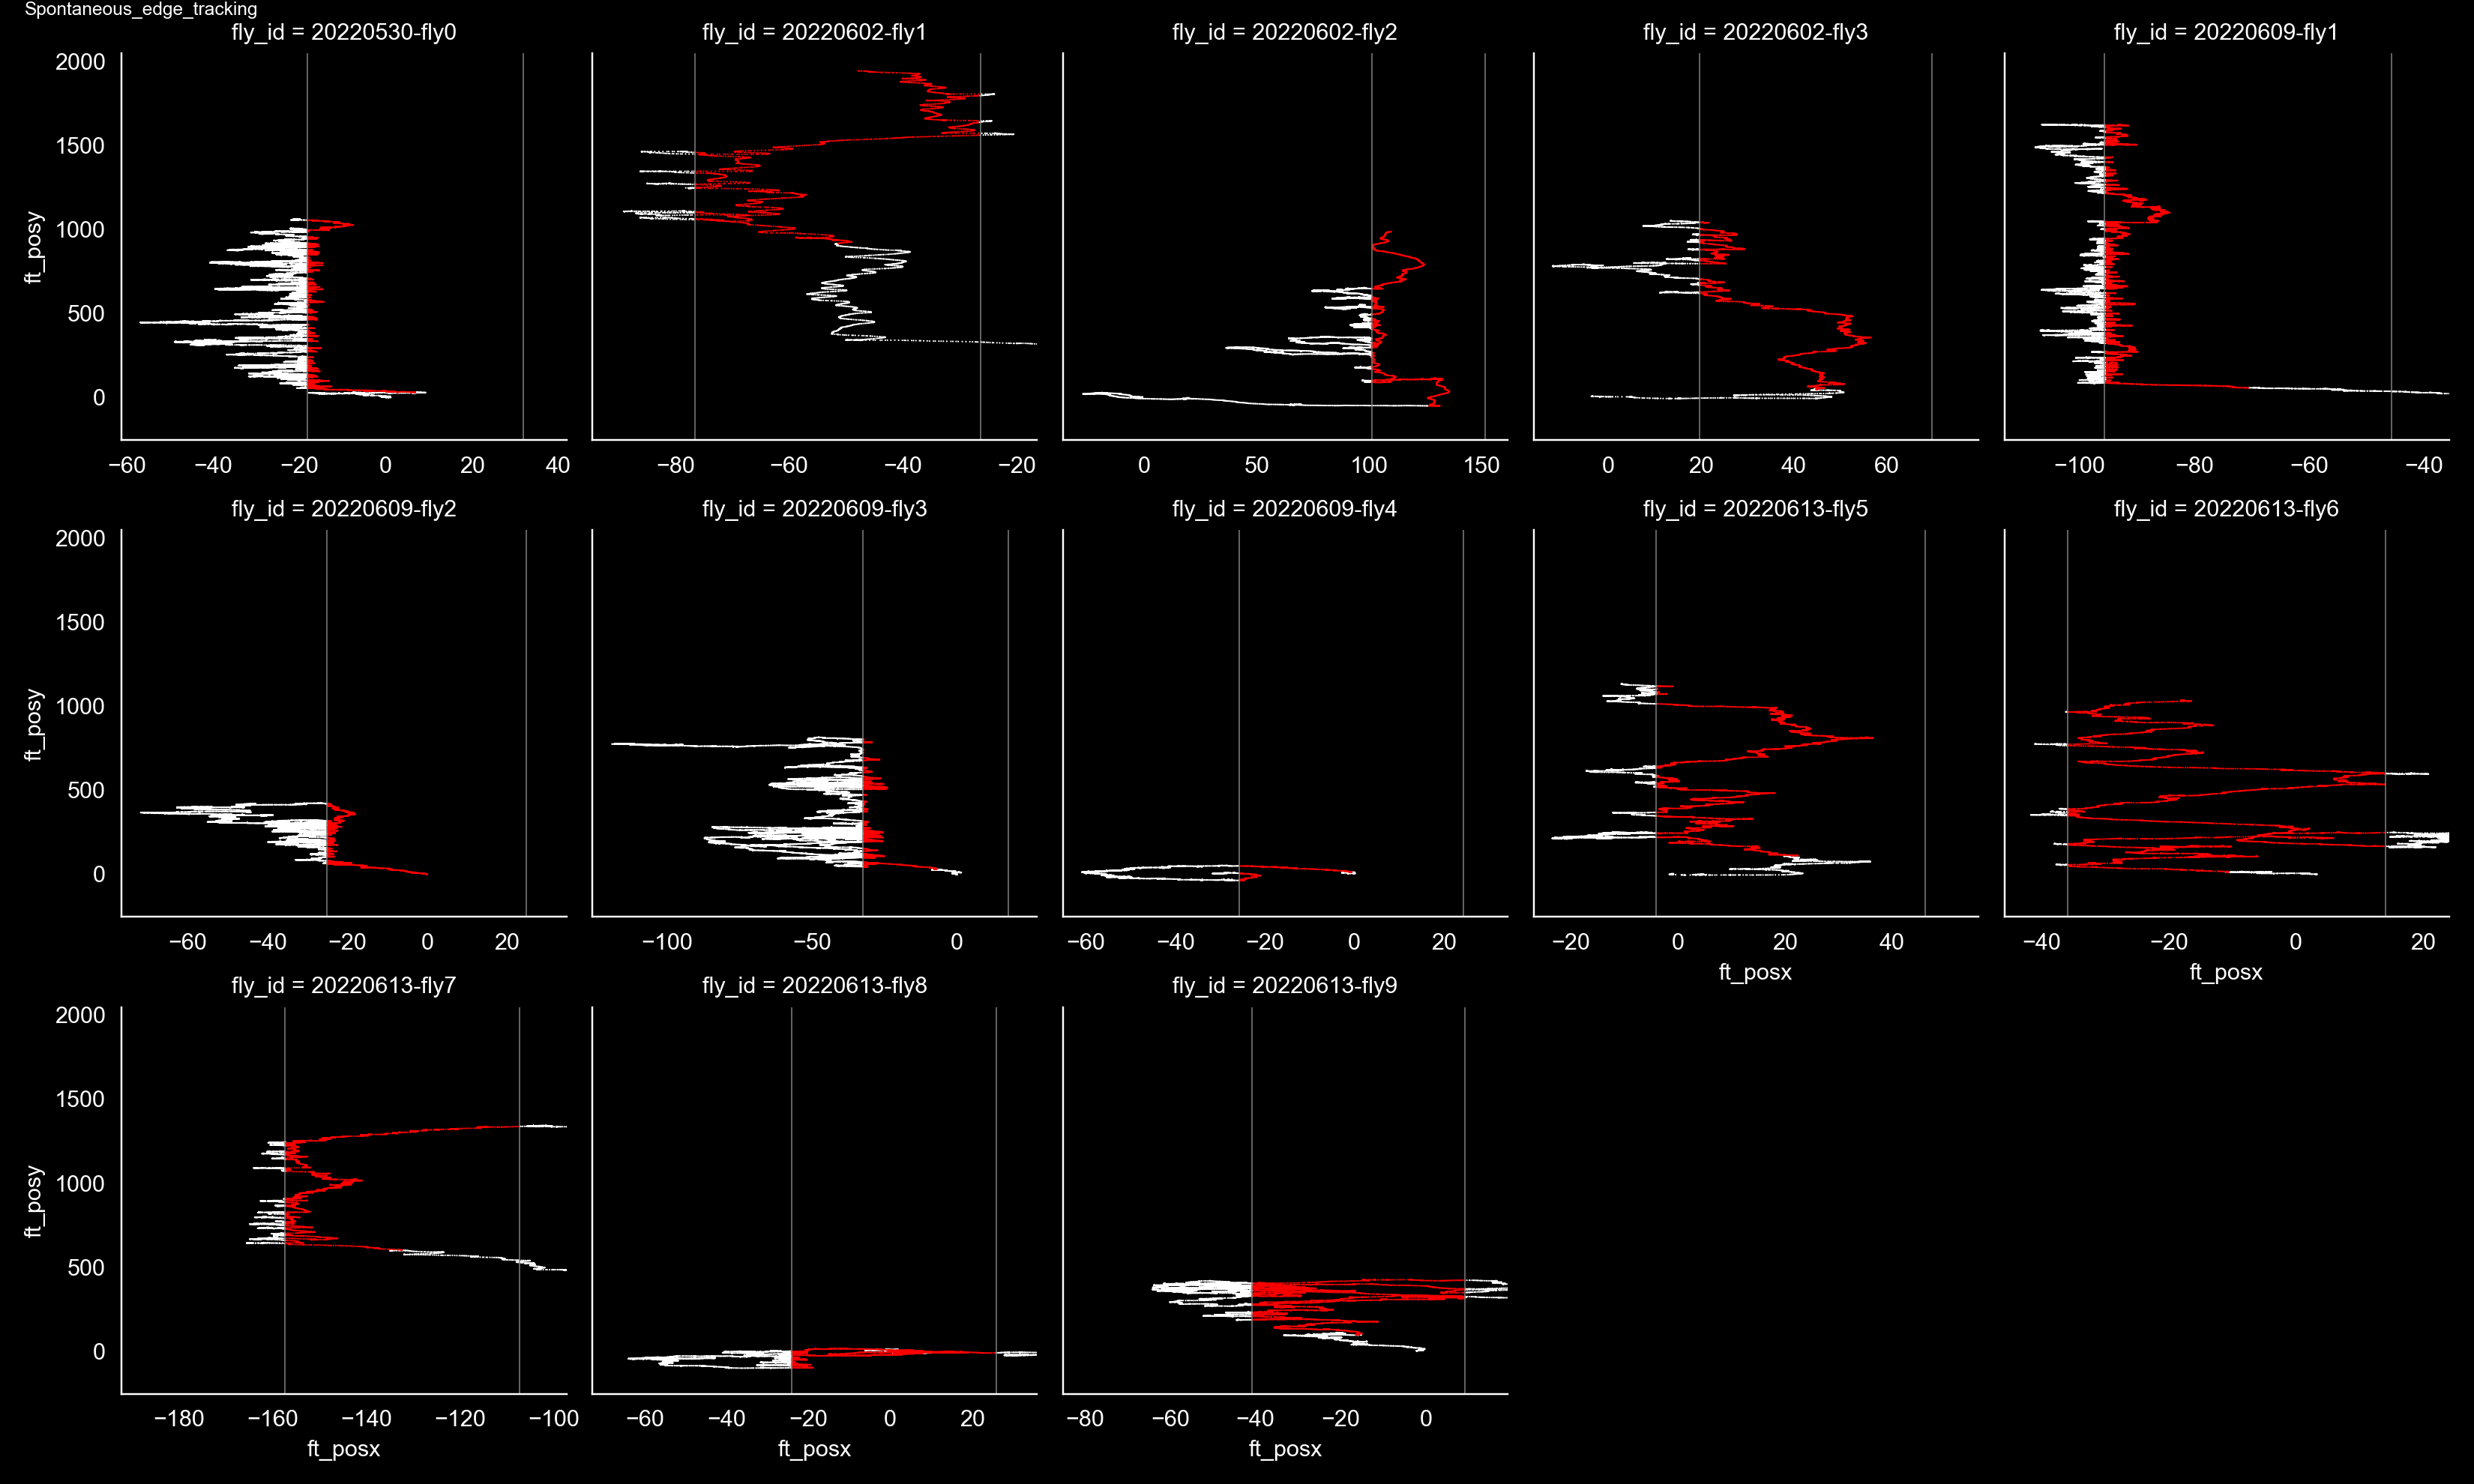

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_20541/262593038.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fly_id, currdf in plotdf.groupby(['fly_id']):


In [91]:
# plot
hue_varname='instrip'
palette={True: 'r', False: 'w'}
start_at_odor = True
odor_width=50
odor_lc='lightgray'
odor_lw=0.5
conds=['spontaneoustracking'] #'odor', 'reinforced']
# -----
plotdf = df0.copy()
g = sns.FacetGrid(plotdf,  col='fly_id', col_wrap=5, sharex=False)
g.map_dataframe(sns.scatterplot, x="ft_posx", y="ft_posy", hue=hue_varname,
               s=0.5, edgecolor='none', palette=palette) #, palette=palette)
pl.show()
util.label_figure(g.fig, experiment)

# add odor corridor to facet grid
for fly_id, currdf in plotdf.groupby(['fly_id']):
    cond_ix = conds.index(cond)
    fly_ix = fly_ids.index(fly_id)
    ax = g.axes[fly_ix]
    odor_xmin, odor_xmax = odor_borders[fly_id]
    butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax)

figname = 'trajectory_all-flies'
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname))) #, dpi=dpi)


# example fly

In [270]:
def plot_overlay_rdp_v_smoothed(df_, boutlist=None, nr=4, nc=6):
    if boutlist is None:
        boutlist = list(np.arange(1, nr*nc))
    fig, axes = pl.subplots(nr, nc, figsize=(10,6))
    for ax, bnum in zip(axes.flat, boutlist):
        b_ = df_[(df_['boutnum']==bnum)].copy()
        ax.plot(b_['ft_posx'], b_['ft_posy'], 'w', alpha=1, lw=0.5)
        ax.plot(b_[b_['rdp_posx']]['ft_posx'], b_[b_['rdp_posy']]['ft_posy'], 'r', alpha=1, lw=0.5)
        ax.plot(b_['smoothed_ft_posx'], b_['smoothed_ft_posy'], 'cornflowerblue', alpha=0.5)
        ax.scatter(b_[b_['rdp_posx']]['ft_posx'], b_[b_['rdp_posy']]['ft_posy'], 
                   c=b_[b_['rdp_posy']]['speed'], alpha=1, s=3)
        ax.set_title(bnum)
    for ax in axes.flat:
        ax.set_aspect('equal')
        ax.axis('off')
    legh = [mpl.lines.Line2D([0], [0], color='w', lw=2, label='orig'),
            mpl.lines.Line2D([0], [0], color='b', lw=2, label='smoothed ({})'.format(smooth_window)),
           mpl.lines.Line2D([0], [0], color='r', lw=2, label='RDP')]
    axes.flat[nc-1].legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left')
    return fig

In [11]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [264]:
DF = butil.process_df(df0) #, conditions=['odor'])

In [265]:
fly_id = fly_ids[0]
print(fly_id)
#df = DF[(DF['fly_id']==fly_id) & (DF['condition']=='odor')].copy()
df_ = DF[DF['fly_id']==fly_id].copy()
#df_ = DF[(DF['fly_id']==fly_id)].copy

20220530-fly0


#### smooth vs. RDP

In [266]:
smooth_window=11
rdp_epsilon=0.5 #0.5 # distance unit (usually, 1mm)
for varname in ['ft_posx', 'ft_posy']:
    df_ = butil.smooth_traces(df_, varname=varname, window_size=smooth_window)
df_ = butil.add_rdp_by_bout(df_, epsilon=rdp_epsilon)

<IPython.core.display.Javascript object>


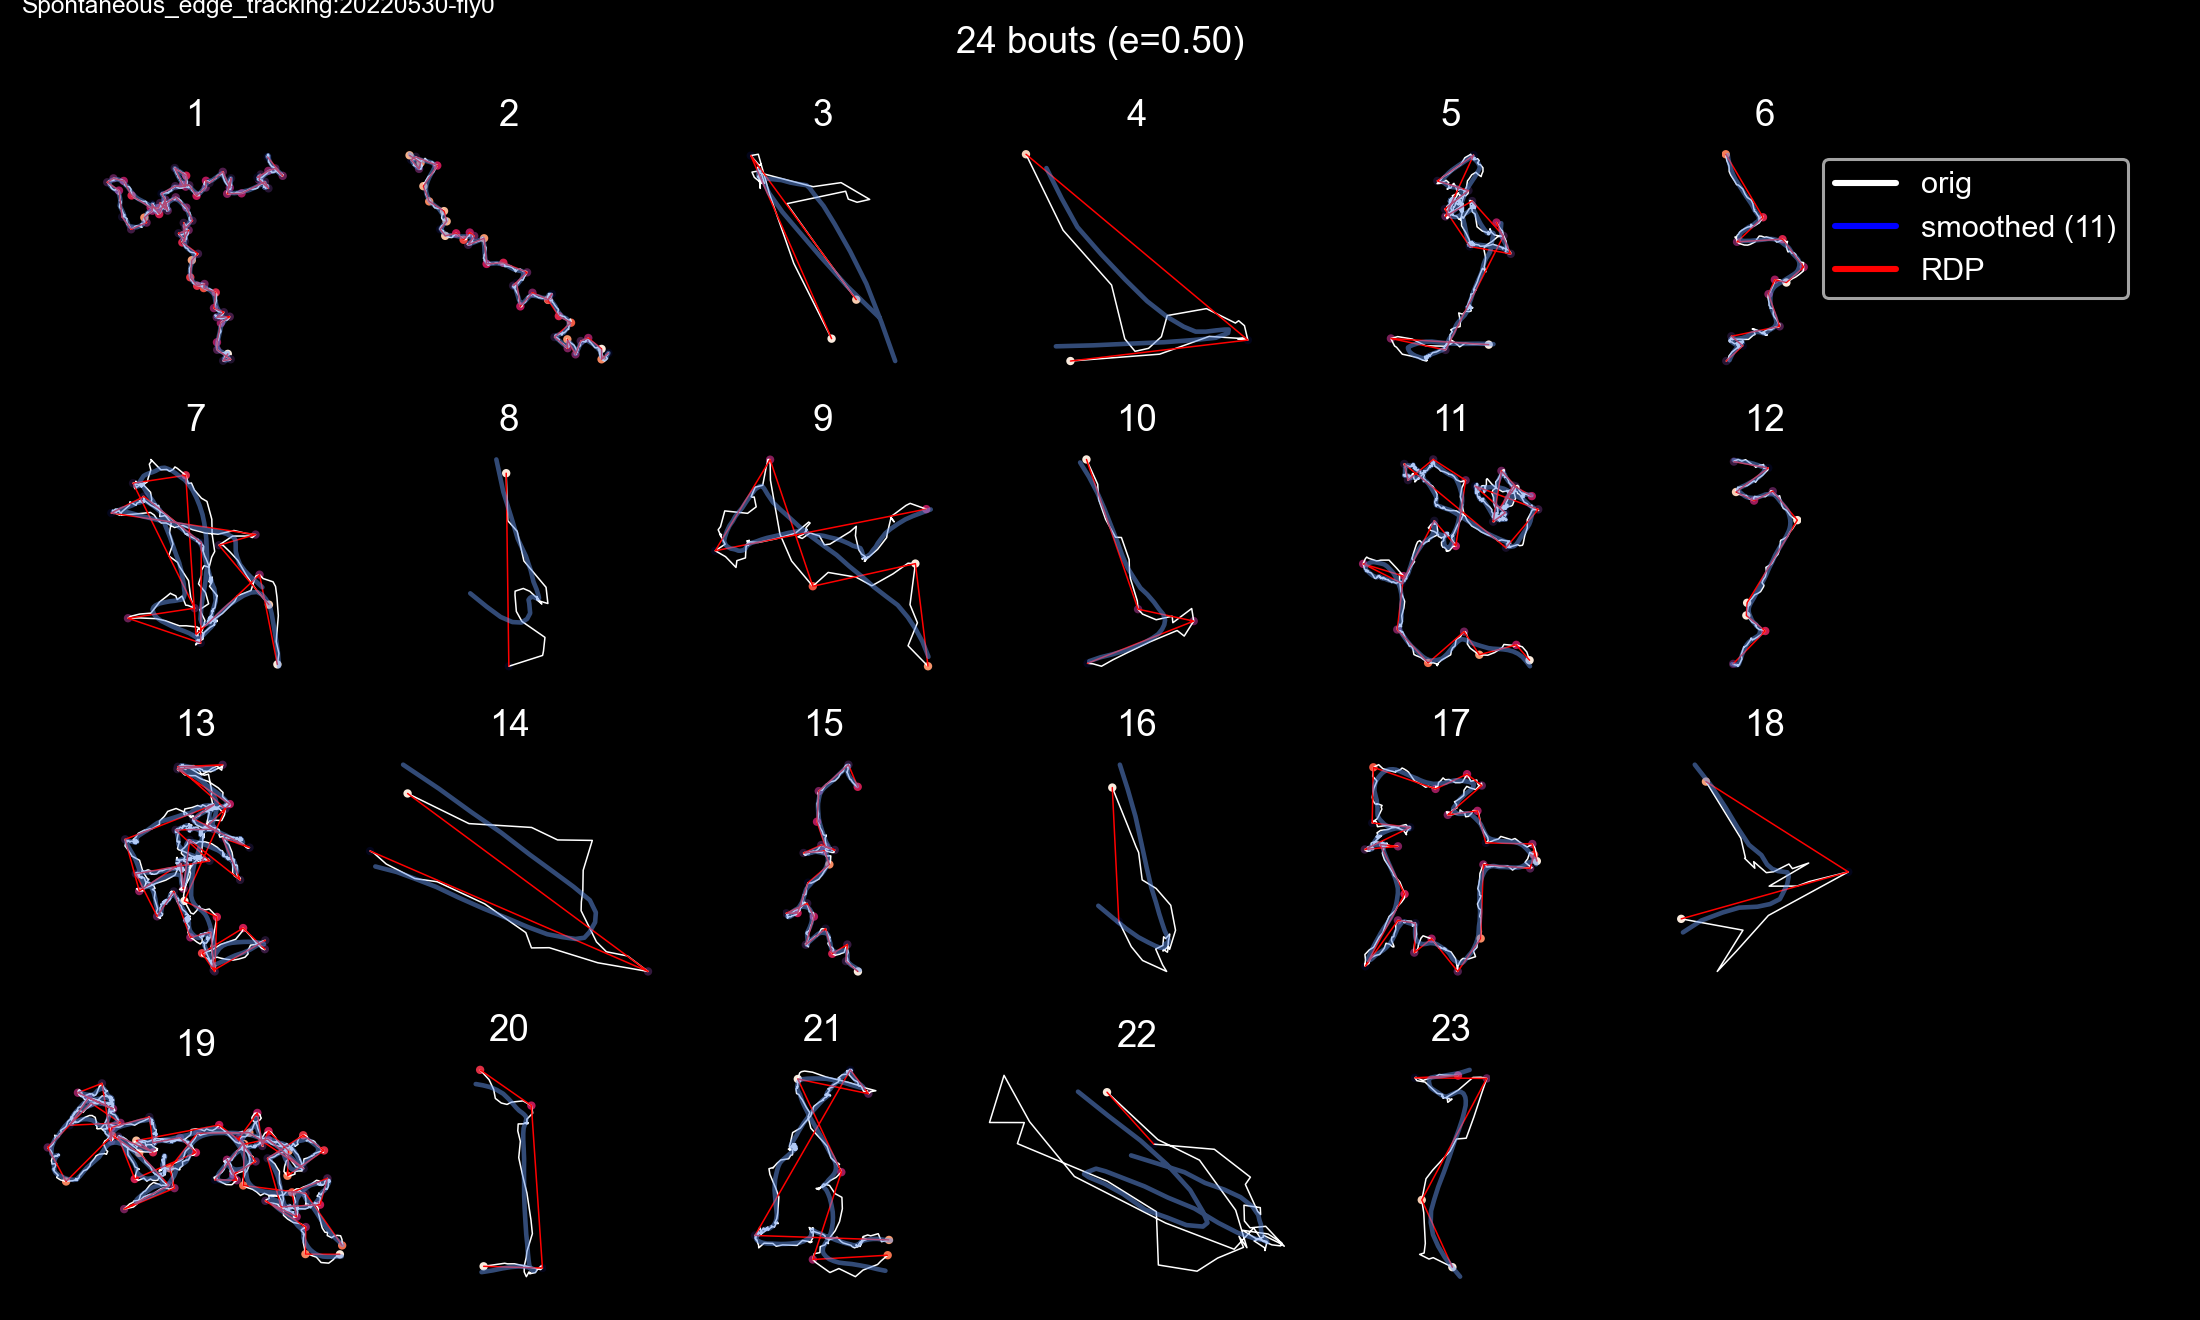

rdp-0p5_20220530-fly0
/Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking/rdp


In [271]:
nr=4
nc=6
nbouts_plot=nc*nr
fig = plot_overlay_rdp_v_smoothed(df_, boutlist=None, nr=nr, nc=nc)
fig.suptitle('{} bouts (e={:.2f})'.format(nbouts_plot, rdp_epsilon))
util.label_figure(fig, '{}:{}'.format(experiment, fly_id))
pl.tight_layout()

figname = 'rdp-{}_{}'.format(str(rdp_epsilon).replace('.', 'p'), fly_id)
print(figname)
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname)))
print(save_dir)

In [238]:
dists_=[]
for bi, (bnum, b_) in enumerate(df_.groupby('boutnum')):
    rdp_points = b_[b_['rdp_posx']].shape[0]
    #if rdp_points <=2 :
    total_dist = b_['euclid_dist'].sum()
    r_ = pd.DataFrame({'boutnum': bnum,
                       'rdp_points': rdp_points,
                       'euclid_dist': b_['euclid_dist'].sum()-b_['euclid_dist'].iloc[0],
                       'upwind_dist': b_['upwind_dist'].sum()-b_['upwind_dist'].iloc[0],
                       'crosswind_dist': b_['crosswind_dist'].sum()-b_['crosswind_dist'].iloc[0],
                      },
                       index=[bi]
                      )
    dists_.append(r_)
rdp_dists = pd.concat(dists_)

<IPython.core.display.Javascript object>


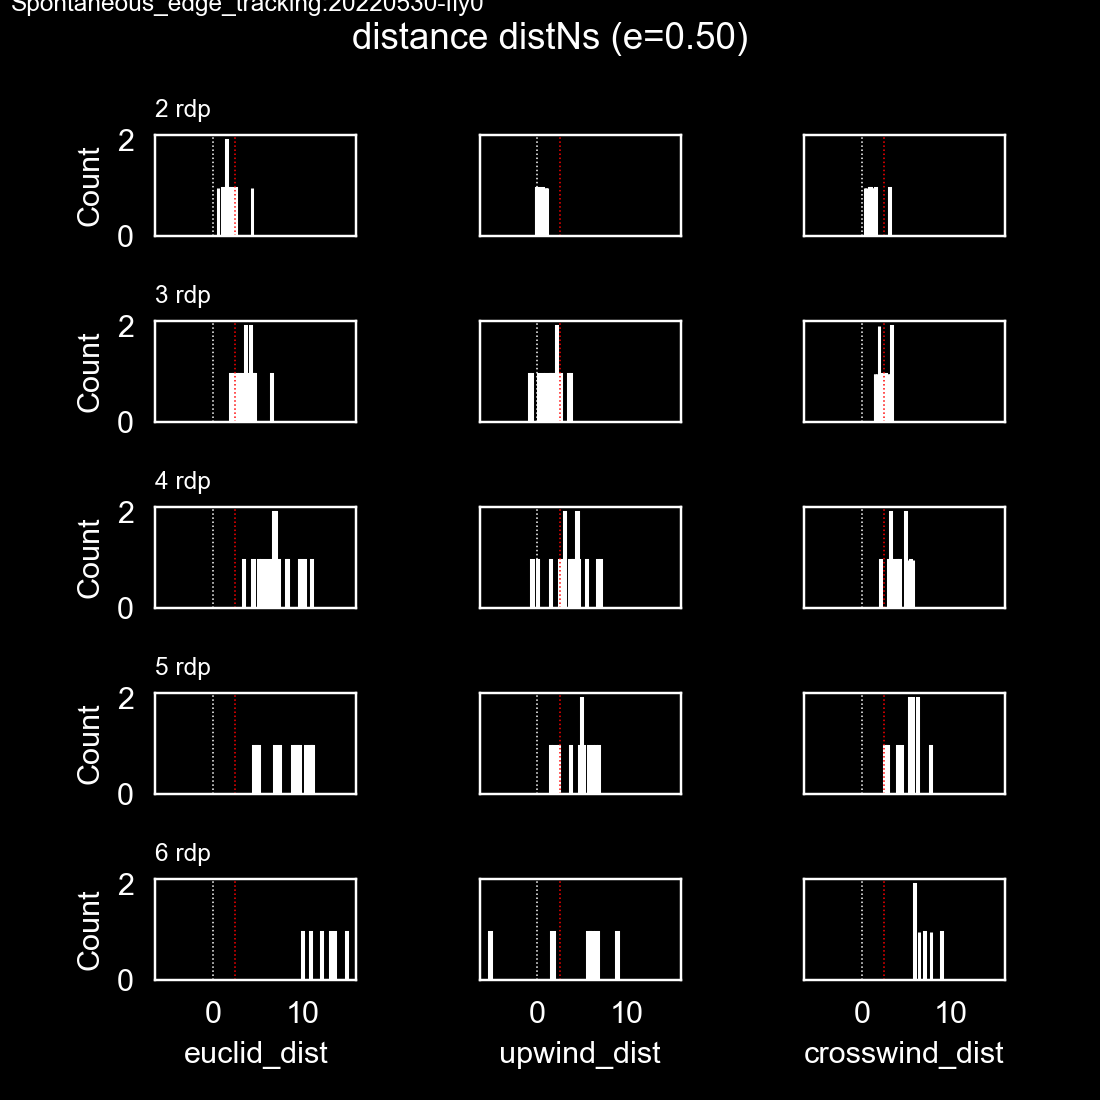

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_20541/1347452997.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ri, (rlen, r_) in enumerate(plot_df.groupby(['rdp_points'])):


20220530-fly0_shortbouts-distance-distns_rdp-0p5
/Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking/rdp


In [249]:
nrows=5
rdp_dist_thresh=2.5
dist_metrics=['euclid_dist', 'upwind_dist', 'crosswind_dist']
fig, axn = pl.subplots(nrows, 3, sharex=True, sharey=True, figsize=(5,5))
plot_df = rdp_dists[rdp_dists['rdp_points']<=10].copy()
for ri, (rlen, r_) in enumerate(plot_df.groupby(['rdp_points'])):
    if ri>(nrows-1):
        break
    for di, distvar in enumerate(dist_metrics):
        ax = axn[ri, di]
        sns.histplot(data=r_, x=distvar, ax=ax, linewidth=1, 
                     facecolor='lightgrey', bins=50)
        ax.axvline(x=0, color='w', linestyle=':', lw=0.5)
        ax.axvline(x=rdp_dist_thresh, color='r', linestyle=':', lw=0.5)
        if di==0:
            ax.set_title('{} rdp'.format(rlen), fontsize=8, loc='left')
        ax.set_box_aspect(0.5)
fig.suptitle('distance distNs (e={:.2f})'.format(rdp_epsilon))
util.label_figure(fig, '{}:{}'.format(experiment, fly_id))
pl.subplots_adjust(hspace=0.7)
pl.tight_layout()

figname = '{}_shortbouts-distance-distns_rdp-{}'.format(fly_id, str(rdp_epsilon).replace('.', 'p'))
print(figname)
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname)))
print(save_dir)

In [245]:
rdp_dists['above_thresh'] = True
rdp_dists.loc[rdp_dists['crosswind_dist']<rdp_dist_thresh, 'above_thresh'] = False
r_ = rdp_dists[(rdp_dists['rdp_points']>2) & (rdp_dists['crosswind_dist']<=rdp_dist_thresh)].copy()

<IPython.core.display.Javascript object>


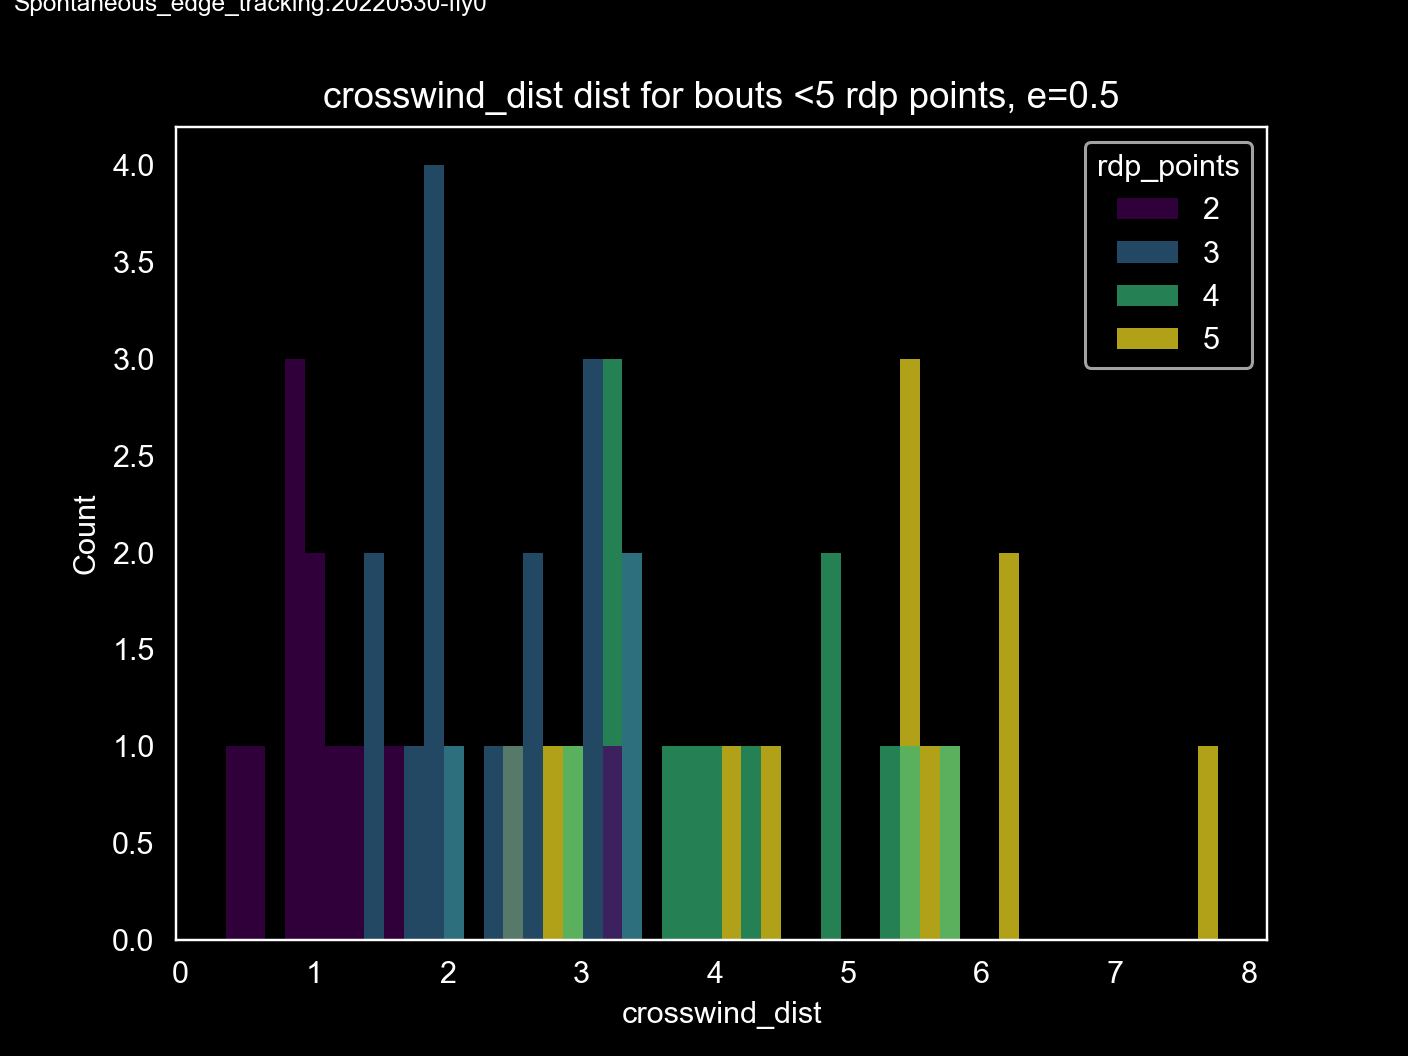

20220530-fly0_shortbouts-crosswind_dist-distns_rdp-0p5
/Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking/rdp


In [250]:
min_rdp=5
fig, ax = pl.subplots()
sns.histplot(data=rdp_dists[rdp_dists['rdp_points']<=min_rdp], hue='rdp_points', #multiple="dodge", shrink=.8,
             x='crosswind_dist' , ax=ax, palette='viridis', bins=50, alpha=0.7, 
             edgecolor='none')
ax.set_title('{} dist for bouts <{} rdp points, e={:.1f}'.format(distvar, min_rdp, rdp_epsilon))
util.label_figure(fig, '{}:{}'.format(experiment, fly_id))

figname = '{}_shortbouts-{}-distns_rdp-{}'.format(fly_id, distvar, str(rdp_epsilon).replace('.', 'p'))
print(figname)
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname)))
print(save_dir)

In [272]:
rdp_dist_thresh=4
below_rdp = rdp_dists[(rdp_dists['crosswind_dist']<rdp_dist_thresh)].copy()
too_short_bouts = below_rdp['boutnum'].unique()
len(too_short_bouts)

41

In [273]:
sorted_by_dist = rdp_dists[rdp_dists['boutnum'].isin(too_short_bouts)]\
                    .sort_values(by='crosswind_dist')['boutnum'].unique()

In [274]:
sorted_by_dist

array([ 58,  74, 102,   8, 144,  92,  28,  16, 124,  36,   3, 110,  18,
        78,   4,  80, 104,  24, 118,  42,  84, 134,  25,  96,  50,  23,
       128, 120,  26,  56,  22,  10, 112,  20, 136,  38,  14,  70,  62,
        94, 132])

In [275]:
plotdf = df_[df_['boutnum'].isin(too_short_bouts)].copy()

<IPython.core.display.Javascript object>


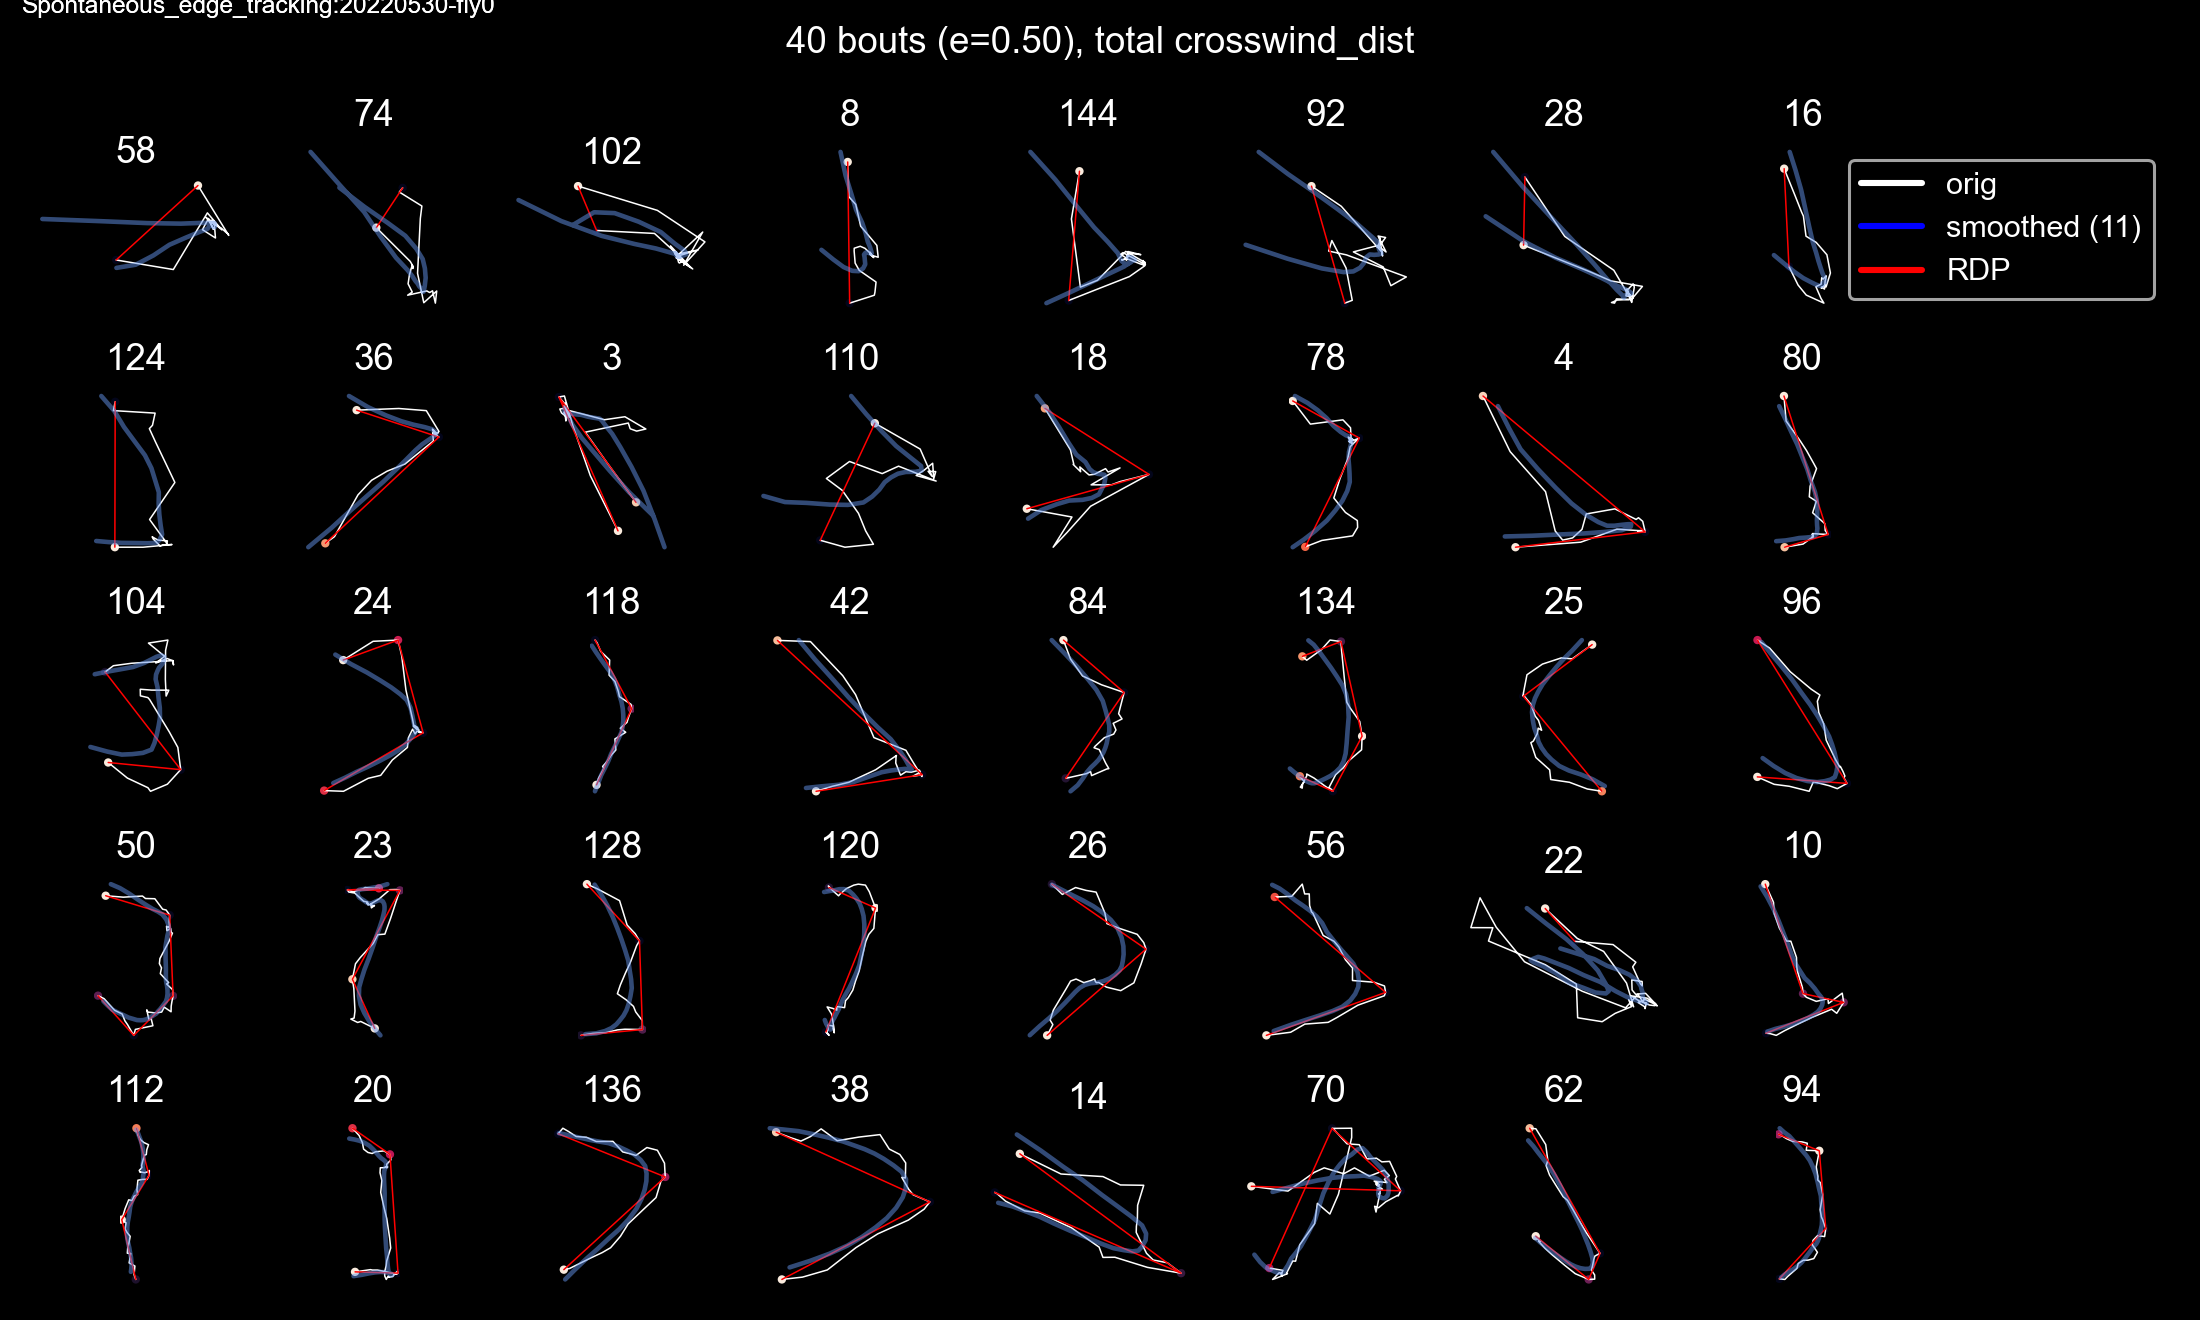

20220530-fly0_shortbouts-crosswind_dist-distns_below-dist-4_rdp-0p5
/Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking/rdp


In [276]:
distvar='crosswind_dist'
nr=5
nc=8
nbouts_plot=nc*nr
fig = plot_overlay_rdp_v_smoothed(plotdf, boutlist=sorted_by_dist, nr=nr, nc=nc)
fig.suptitle('{} bouts (e={:.2f}), total {}'.format(nbouts_plot, rdp_epsilon, distvar))
util.label_figure(fig, '{}:{}'.format(experiment, fly_id))
pl.tight_layout()

util.label_figure(fig, '{}:{}'.format(experiment, fly_id))

figname = '{}_shortbouts-{}-distns_below-dist-{}_rdp-{}'\
                .format(fly_id, distvar, str(rdp_dist_thresh).replace('.', 'p'), str(rdp_epsilon).replace('.', 'p'))
print(figname)
#pl.savefig(os.path.join(save_dir, '{}.png'.format(figname)))
print(save_dir)

<IPython.core.display.Javascript object>


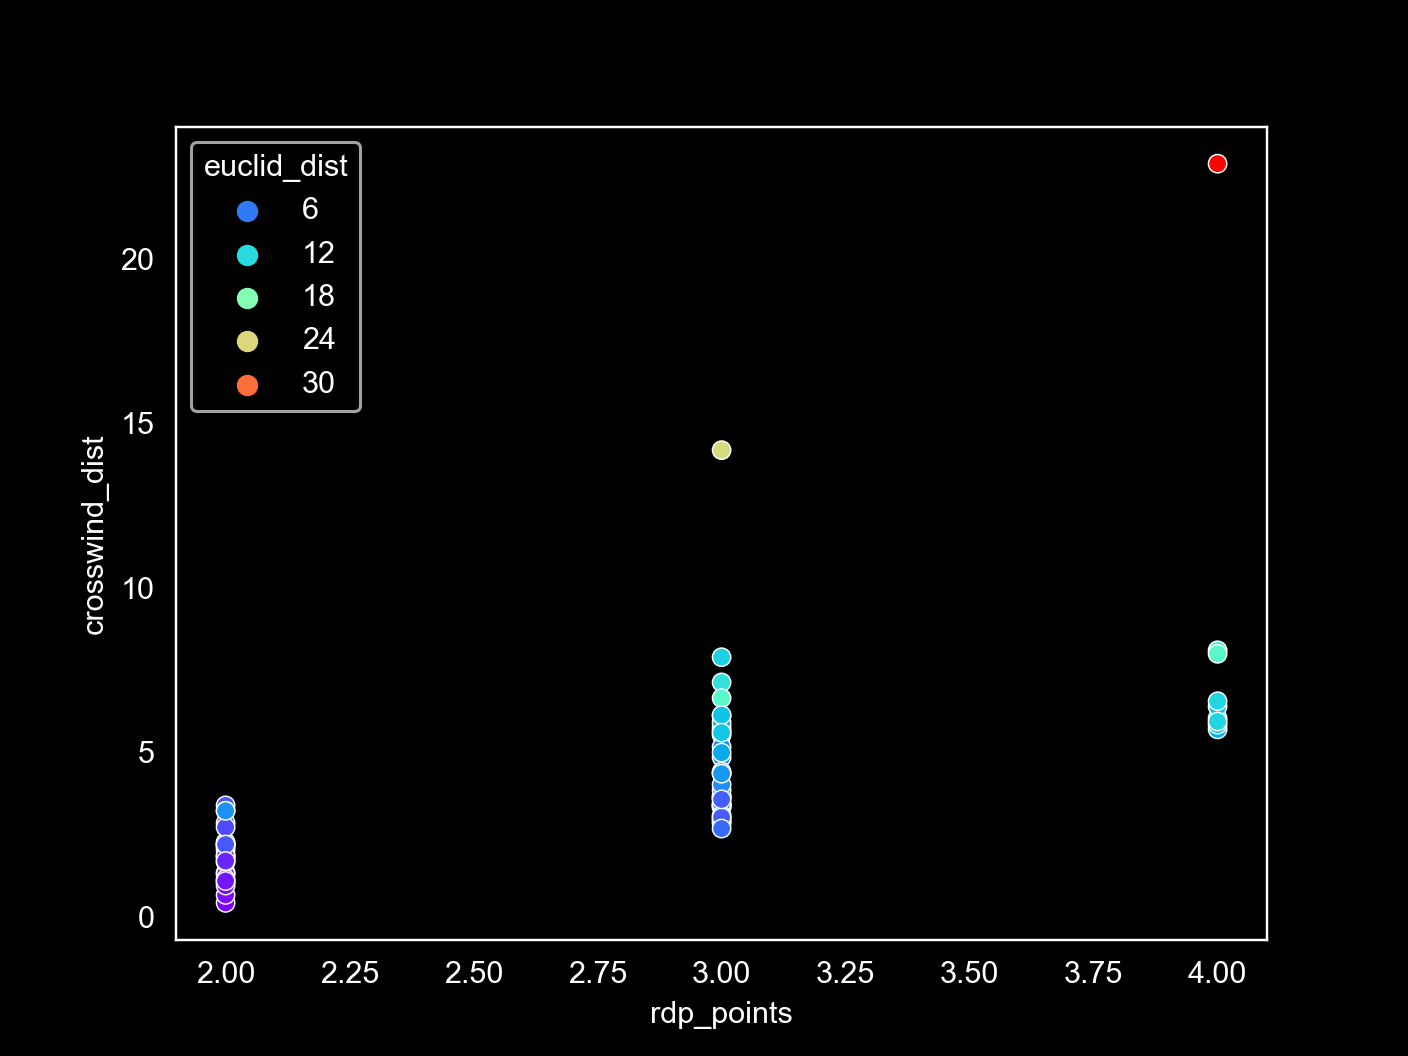

<AxesSubplot: xlabel='rdp_points', ylabel='crosswind_dist'>

In [54]:
fig, ax = pl.subplots()
plot_df = rdp_dists[rdp_dists['rdp_points']<=4].copy()
sns.scatterplot(data=plot_df, y='crosswind_dist', x='rdp_points', 
                hue='euclid_dist', palette='rainbow', ax=ax)